In [1]:
import warnings
warnings.filterwarnings("ignore",category = FutureWarning)

#### Packages

In [89]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Data

In [81]:
data = pd.read_csv('tsdl006.csv', index_col = 'idx', parse_dates=True)
seedNum = 900

In [34]:
target = data.columns[0]

Les données contient les ventes des maison depuis 1965 jusqu'a 1975  ( 131 Mois )

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 1965-01-01 to 1975-12-01
Data columns (total 1 columns):
values    132 non-null int64
dtypes: int64(1)
memory usage: 2.1 KB


In [36]:
data.head()

,values
idx,
1965-01-01,38
1965-02-01,44
1965-03-01,53
1965-04-01,49
1965-05-01,54


In [37]:
data.describe()

,values
count,132.000000
mean,45.356061
std,10.376230
min,23.000000
25%,39.000000
50%,44.000000
75%,52.250000
max,72.000000


##### Line plot

<function matplotlib.pyplot.show(*args, **kw)>

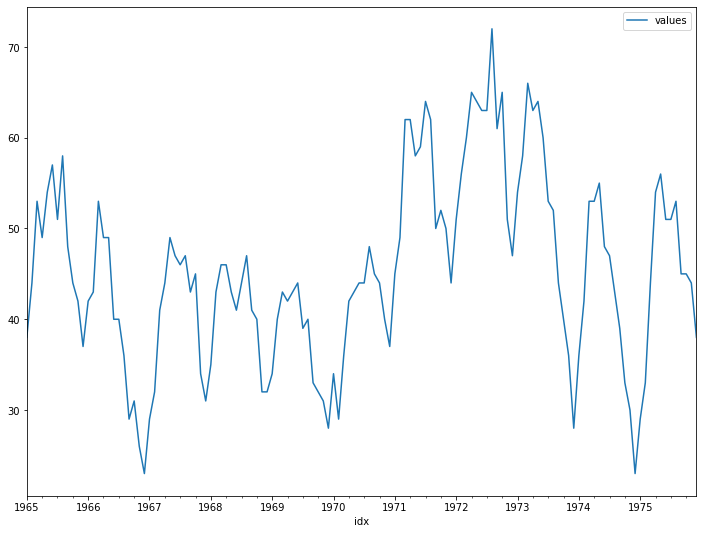

In [38]:
fig, ax = plt.subplots(figsize = (12,9))
data.plot(ax = ax)
plt.show

##### Histogramme

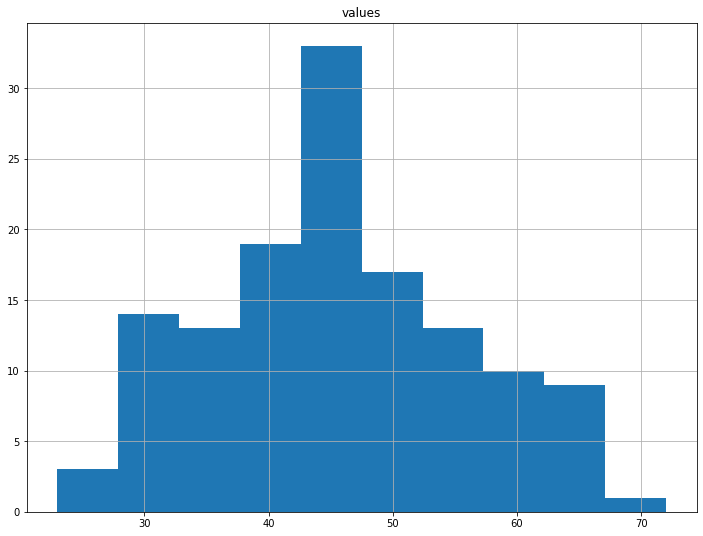

In [39]:
fig, ax = plt.subplots(figsize = (12,9))
data.hist(ax = ax)
plt.show()

##### Lineplot

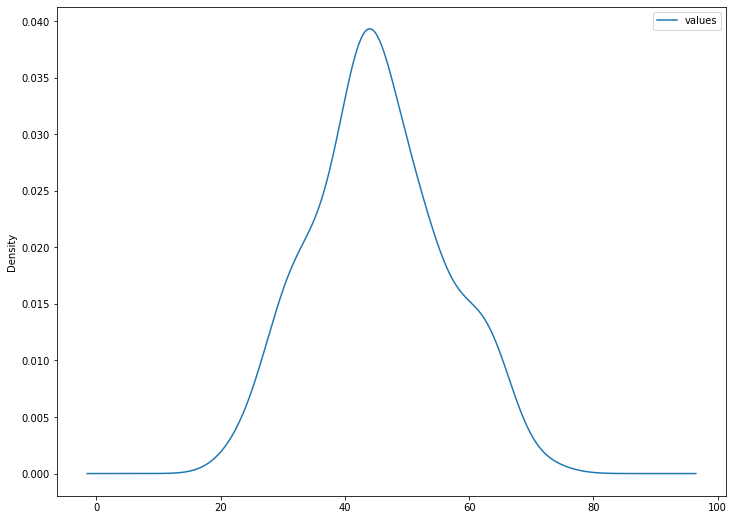

In [40]:
fig, ax = plt.subplots(figsize = (12,9))
data.plot(kind = 'kde', ax = ax)
plt.show()

##### Box Plot

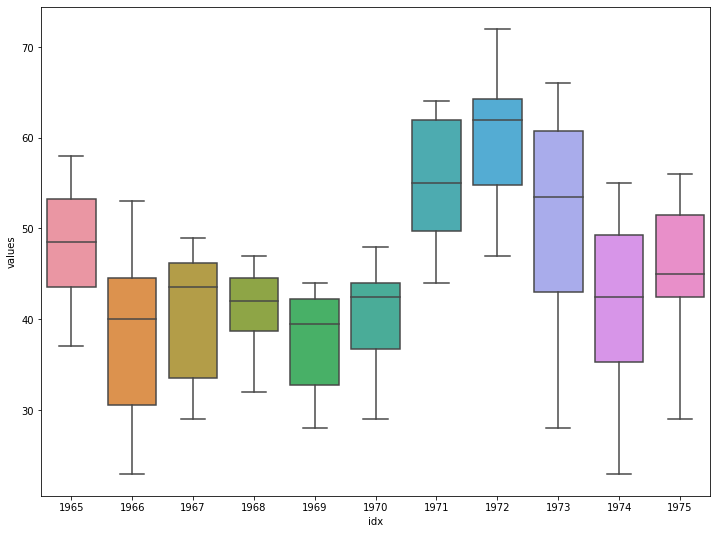

In [41]:
fig, ax  = plt.subplots(figsize = (12,9))
squeezed = data.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax = ax)
plt.show()

##### Transformation des données ( Resample )

In [46]:
time_series   = data
resample_data = data.resample('M')
time_serie    = resample_data.mean()

<function matplotlib.pyplot.show(*args, **kw)>

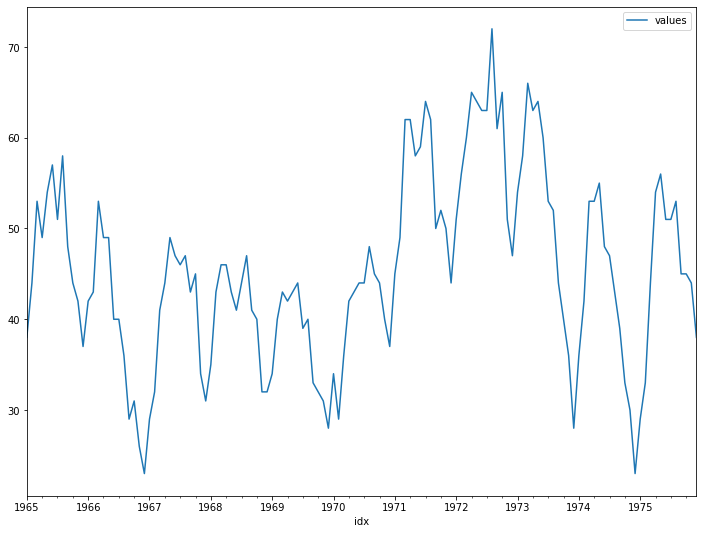

In [47]:
fig, ax = plt.subplots(figsize = (12,9))
time_serie.plot(ax = ax)
plt.show

##### Test de stationnarité

In [55]:
# vérifier la stationnarité des données
from statsmodels.tsa.stattools import adfuller

print(" Test de stationnarité ")
dftest = adfuller(squeezed.index.year, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")

for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    

 > Is the data stationary ?
Test statistic = 0.047
P-value = 0.962
Critical values :
	1%: -3.486055829282407 - The data is not stationary with 99% confidence
	5%: -2.8859430324074076 - The data is not stationary with 95% confidence
	10%: -2.5797850694444446 - The data is not stationary with 90% confidence


##### Décomposition saisonnière

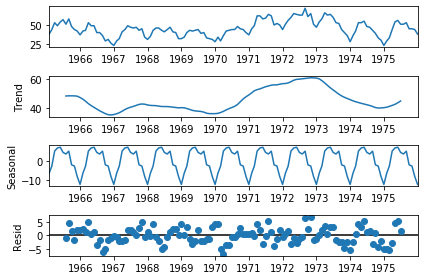

In [49]:
frequence     = 12
decomposition = seasonal_decompose(time_serie, freq = frequence)
decomposition.plot()
plt.show()

##### Création d'un simple modèle

Le modèle suivant consiste à prendre la valeur de J+1 et la sortir comme résultat de préduction du jour J

In [57]:
X                 = data.values
X                 = X.astype('float32')
train_pourcentage = 0.80
train_size        = int(len(X) * train_pourcentage)
test_size         = len(X) - train_size
train_ts, test_ts = X[0:train_size] , X[train_size:]

In [64]:
# walk-forward validation
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test_ts[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE = : %.3f' % rmse)

>Predicted=44.000, Expected= 40
>Predicted=40.000, Expected= 36
>Predicted=36.000, Expected= 28
>Predicted=28.000, Expected= 36
>Predicted=36.000, Expected= 42
>Predicted=42.000, Expected= 53
>Predicted=53.000, Expected= 53
>Predicted=53.000, Expected= 55
>Predicted=55.000, Expected= 48
>Predicted=48.000, Expected= 47
>Predicted=47.000, Expected= 43
>Predicted=43.000, Expected= 39
>Predicted=39.000, Expected= 33
>Predicted=33.000, Expected= 30
>Predicted=30.000, Expected= 23
>Predicted=23.000, Expected= 29
>Predicted=29.000, Expected= 33
>Predicted=33.000, Expected= 44
>Predicted=44.000, Expected= 54
>Predicted=54.000, Expected= 56
>Predicted=56.000, Expected= 51
>Predicted=51.000, Expected= 51
>Predicted=51.000, Expected= 53
>Predicted=53.000, Expected= 45
>Predicted=45.000, Expected= 45
>Predicted=45.000, Expected= 44
>Predicted=44.000, Expected= 38
RMSE for the persistent model is: 5.786


##### Training du modèle avec l'algorithme ARIMA

In [76]:
#Initialisation des paramètres pour l'algorithem ARIMA non saisonnière
start_p = 0
start_d = 0
start_q = 0
max_p = 5
max_d = 2
max_q = 5

In [79]:
#Initialisation des paramètres pour l'algorithem ARIMA saisonnière
start_P = 0
start_D = 0
start_Q = 0
max_P = 2
max_D = 1
max_Q = 2

In [82]:
# Choix des paramètres avec Grid Search
if (frequence == 0):
    autogrid_results = pm.auto_arima(data, start_p = start_p, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    autogrid_results = pm.auto_arima(data, start_p = start_p, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = frequence, start_P = start_P, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)


Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=995.229, BIC=1000.994, Time=0.413 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 12) (constant=True); AIC=954.269, BIC=962.918, Time=0.280 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 2, 12) (constant=True); AIC=953.525, BIC=965.056, Time=0.466 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=954.379, BIC=963.027, Time=0.320 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 12) (constant=True); AIC=953.206, BIC=964.737, Time=0.524 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 2, 12) (constant=True); AIC=963.090, BIC=977.504, Time=1.775 seconds
Fit ARIMA: (0, 0, 0)x(2, 0, 0, 12) (constant=True); AIC=953.757, BIC=965.289, Time=2.261 seconds
Fit ARIMA: (0, 0, 0)x(2, 0, 1, 12) (constant=True); AIC=954.970, BIC=969.384, Time=1.840 seconds
Fit ARIMA: (0, 0, 0)x(2, 0, 2, 12) (constant=True); AIC=979.655, BIC=996.952, Time=2.749 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 12) (constant=True); AIC=897.286, BIC=905.934, Time=0.059 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1

C:\ProgramData\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (1, 0, 1)x(1, 0, 2, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: (1, 0, 1)x(1, 0, 2, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 0, 12) (constant=True); AIC=764.044, BIC=781.341, Time=1.718 seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 1, 12) (constant=True); AIC=743.578, BIC=763.758, Time=2.345 seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 2, 12) (constant=True); AIC=745.100, BIC=768.162, Time=3.670 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 12) (constant=True); AIC=804.862, BIC=819.276, Time=0.192 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 1, 12) (constant=True); AIC=781.691, BIC=798.988, Time=0.432 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 2, 12) (constant=True); AIC=776.835, BIC=797.015, Time=1.176 seconds
Fit ARIMA: (1, 0, 2)x(1, 0, 0, 12) (constant=True); AIC=768.224, BIC=785.521, Time=0.676 seconds
Fit ARIMA: (1, 0, 2)x(1, 0, 1, 12) (constant=True); AIC=755.371, BIC=775.550, Time=1.292 seconds
Fit ARIMA: (1, 0, 2)x(1, 0, 2, 12) (constant=True); AIC=805.208, BIC=828.271, Time=3.839 seconds
Fit ARIMA: (1, 0, 2)x(2, 0, 0, 12) (cons

C:\ProgramData\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (2, 0, 0)x(2, 0, 1, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: (2, 0, 0)x(2, 0, 1, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (2, 0, 0)x(2, 0, 2, 12) (constant=True); AIC=744.838, BIC=767.901, Time=2.889 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 12) (constant=True); AIC=812.682, BIC=827.096, Time=0.313 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 1, 12) (constant=True); AIC=784.116, BIC=801.413, Time=0.738 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 2, 12) (constant=True); AIC=781.295, BIC=801.474, Time=1.629 seconds
Fit ARIMA: (2, 0, 1)x(1, 0, 0, 12) (constant=True); AIC=767.876, BIC=785.173, Time=0.789 seconds
Fit ARIMA: (2, 0, 1)x(1, 0, 1, 12) (constant=True); AIC=743.868, BIC=764.048, Time=1.065 seconds
Fit ARIMA: (2, 0, 1)x(1, 0, 2, 12) (constant=True); AIC=746.463, BIC=769.525, Time=2.922 seconds
Fit ARIMA: (2, 0, 1)x(2, 0, 0, 12) (constant=True); AIC=764.401, BIC=784.581, Time=2.702 seconds
Fit ARIMA: (2, 0, 1)x(2, 0, 1, 12) (constant=True); AIC=746.063, BIC=769.125, Time=3.391 seconds
Fit ARIMA: (2, 0, 1)x(2, 0, 2, 12) (cons

Fit ARIMA: (3, 0, 4)x(0, 0, 2, 12) (constant=True); AIC=780.324, BIC=812.034, Time=10.426 seconds
Fit ARIMA: (3, 0, 4)x(1, 0, 0, 12) (constant=True); AIC=772.172, BIC=801.000, Time=1.499 seconds
Fit ARIMA: (3, 0, 4)x(1, 0, 1, 12) (constant=True); AIC=746.873, BIC=778.584, Time=1.801 seconds
Fit ARIMA: (3, 0, 4)x(1, 0, 2, 12) (constant=True); AIC=750.918, BIC=785.512, Time=5.776 seconds
Fit ARIMA: (3, 0, 4)x(2, 0, 0, 12) (constant=True); AIC=769.632, BIC=801.343, Time=4.175 seconds
Fit ARIMA: (3, 0, 4)x(2, 0, 1, 12) (constant=True); AIC=749.745, BIC=784.339, Time=4.583 seconds
Fit ARIMA: (3, 0, 4)x(2, 0, 2, 12) (constant=True); AIC=752.862, BIC=790.338, Time=4.880 seconds
Fit ARIMA: (3, 0, 5)x(0, 0, 0, 12) (constant=True); AIC=790.727, BIC=819.555, Time=0.887 seconds
Fit ARIMA: (3, 0, 5)x(0, 0, 1, 12) (constant=True); AIC=775.726, BIC=807.437, Time=1.600 seconds
Fit ARIMA: (3, 0, 5)x(0, 0, 2, 12) (constant=True); AIC=774.934, BIC=809.528, Time=4.417 seconds
Fit ARIMA: (3, 0, 5)x(1, 0, 0

Fit ARIMA: (5, 0, 1)x(2, 0, 0, 12) (constant=True); AIC=765.724, BIC=794.552, Time=3.909 seconds
Fit ARIMA: (5, 0, 1)x(2, 0, 1, 12) (constant=True); AIC=747.837, BIC=779.548, Time=4.954 seconds
Fit ARIMA: (5, 0, 1)x(2, 0, 2, 12) (constant=True); AIC=750.057, BIC=784.651, Time=4.846 seconds
Fit ARIMA: (5, 0, 2)x(0, 0, 0, 12) (constant=True); AIC=805.211, BIC=831.156, Time=0.692 seconds
Fit ARIMA: (5, 0, 2)x(0, 0, 1, 12) (constant=True); AIC=787.708, BIC=816.536, Time=1.386 seconds
Fit ARIMA: (5, 0, 2)x(0, 0, 2, 12) (constant=True); AIC=780.361, BIC=812.071, Time=4.037 seconds
Fit ARIMA: (5, 0, 2)x(1, 0, 0, 12) (constant=True); AIC=771.453, BIC=800.281, Time=1.475 seconds
Fit ARIMA: (5, 0, 2)x(1, 0, 1, 12) (constant=True); AIC=748.389, BIC=780.099, Time=1.929 seconds
Fit ARIMA: (5, 0, 2)x(1, 0, 2, 12) (constant=True); AIC=749.798, BIC=784.391, Time=4.613 seconds
Fit ARIMA: (5, 0, 2)x(2, 0, 0, 12) (constant=True); AIC=771.751, BIC=803.461, Time=4.738 seconds
Fit ARIMA: (5, 0, 2)x(2, 0, 1,

In [143]:
# Choix des paramètres automatiquement
n_fits = int(max_p * max_d * max_q * max_P * max_D * max_Q * 0.30)
if (frequence == 0):
    randgrid_results = pm.auto_arima(time_series, start_p = start_p, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)
else:
    randgrid_results = pm.auto_arima(time_series, start_p = start_p, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = frequence, start_P = start_P, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA: (5, 0, 0)x(2, 0, 2, 12) (constant=True); AIC=751.116, BIC=782.827, Time=5.638 seconds
Fit ARIMA: (3, 0, 2)x(0, 0, 2, 12) (constant=True); AIC=771.835, BIC=797.780, Time=2.480 seconds
Fit ARIMA: (4, 0, 1)x(2, 0, 1, 12) (constant=True); AIC=746.829, BIC=775.657, Time=4.325 seconds
Fit ARIMA: (2, 0, 5)x(0, 0, 0, 12) (constant=True); AIC=788.993, BIC=814.939, Time=0.762 seconds
Fit ARIMA: (2, 0, 5)x(1, 0, 2, 12) (constant=True); AIC=935.946, BIC=970.540, Time=6.224 seconds
Fit ARIMA: (0, 0, 2)x(1, 0, 1, 12) (constant=True); AIC=814.412, BIC=831.709, Time=1.159 seconds
Fit ARIMA: (4, 0, 1)x(1, 0, 0, 12) (constant=True); AIC=767.564, BIC=790.626, Time=1.135 seconds
Fit ARIMA: (0, 0, 5)x(0, 0, 1, 12) (constant=True); AIC=788.291, BIC=811.353, Time=0.714 seconds
Fit ARIMA: (1, 0, 2)x(2, 0, 0, 12) (constant=True); AIC=763.990, BIC=784.170, Time=2.736 seconds
Fit ARIMA: (1, 0, 5)x(0, 0, 1, 12) (constant=True); AIC=785.636, BIC=811.581, Time=1.388 seconds
Fit ARIMA: (4, 0, 4)x(1, 0, 2,

In [83]:
#Résultat obtenu par Grid Search
autogrid_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -365.339
Date:                              Wed, 10 Jun 2020   AIC                            740.679
Time:                                      17:48:08   BIC                            755.093
Sample:                                           0   HQIC                           746.536
                                              - 132                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0105      0.073      0.144      0.885      -0.132       0.153
ar.L1          0.9016      0.034     26.593      0.000       0.835       0.968
ar.S.L12       0.9977      0.016     61.821      0.000       0.966       1.029
ma.S.L12      -0.9260      0.251     -3.695      0.000      -1.417      -0.435
sigma2        11.9641      2.686      4.454      0.000       6.700      17.228
===================================================================================
Ljung-Box (Q):                       34.36   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.72   Prob(JB):                         0.74
Heteroskedasticity (H):               1.04   Skew:                            -0.15
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [145]:
#Résultat obtenu par La recherche automatique
randgrid_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -365.339
Date:                              Wed, 10 Jun 2020   AIC                            740.679
Time:                                      18:22:25   BIC                            755.093
Sample:                                           0   HQIC                           746.536
                                              - 132                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0105      0.073      0.144      0.885      -0.132       0.153
ar.L1          0.9016      0.034     26.593      0.000       0.835       0.968
ar.S.L12       0.9977      0.016     61.821      0.000       0.966       1.029
ma.S.L12      -0.9260      0.251     -3.695      0.000      -1.417      -0.435
sigma2        11.9641      2.686      4.454      0.000       6.700      17.228
===================================================================================
Ljung-Box (Q):                       34.36   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.72   Prob(JB):                         0.74
Heteroskedasticity (H):               1.04   Skew:                            -0.15
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


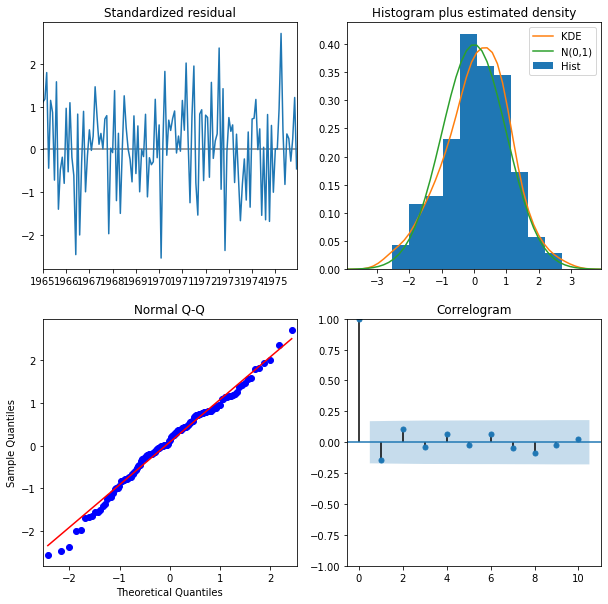

In [149]:
#ARIMA 
Nsorder = randgrid_results.order
Sorder  = randgrid_results.seasonal_order
model   = SARIMAX(data, order = order, seasonal_order = Sorder)
results = model.fit(dispo = False)
results.plot_diagnostics(figsize=(10,10))
plt.show()

In [152]:
#Predictions
results.forecast(15)

1976-01-01    43.327281
1976-02-01    46.703674
1976-03-01    54.085717
1976-04-01    54.956981
1976-05-01    55.498425
1976-06-01    53.161545
1976-07-01    51.917404
1976-08-01    53.073795
1976-09-01    45.967593
1976-10-01    45.152627
1976-11-01    40.256568
1976-12-01    35.890406
1977-01-01    41.299158
1977-02-01    44.754695
1977-03-01    52.210377
Freq: MS, dtype: float64